## grid攻略

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from env import GridEnv


## アルゴリズムの流れ
1. Qテーブル初期化
2. 各エピソードのループ  
   2-1. 状態sを取得  
   2-2. ε-greedyで行動aを選択  
   2-3. 環境を1ステップ進める → r, s' を取得  
   2-4. Q値 Q(s, a) を更新  
   2-5. s ← s'  
   2-6. エピソード終了まで繰り返し  
3. 学習の記録（報酬など）  

- Q値の更新式  
   $Q(s,a)←Q(s,a)+\alpha[r+\gamma \cdot max{Q(s', a')-Q(s,a)}]$

In [2]:
# 行動を選択(ε-greedy法を使用)
def choice_action(q_table, state, ipsilon=0.2)->int:
    # 探索
    if np.random.rand() < ipsilon:
        return np.random.choice(4)

    # 活用
    else:
        return np.argmax(q_table[state])
    
# 今の状態と取った行動により、Q-tableを更新
def update_q(q_table, now_state, action, next_state, reward, gamma=0.9, lr=0.05):
    best_q = np.max(q_table[next_state])
    # 報酬値 + 割引率 x 次の状態での最大価値
    td_target = reward + gamma * best_q
    q_table[now_state, action] += lr * (td_target - q_table[now_state, action])
    return q_table

In [7]:
# 環境の実体化
grid_env = GridEnv()

# Qテーブルの初期化
q_table = np.zeros((grid_env.size**2, grid_env.action_space), np.float32)

# ハイパパラメータの設定
# 学習エピソード
episode = 1_000
# 最大ステップ数
max_step = 20
# 割引率
gamma = 0.9
# 探索率
ipsilon = 0.3 
# 学習率
lr = 0.01 

# log記録用
reward_log = []

# 実際の学習ループ
for i in range(episode):
    total_reward = 0
    for _ in range(max_step):
        now_state = grid_env.index_state
        # 行動の決定
        action = choice_action(
                            q_table=q_table,
                            state=now_state
                            )

        # 行動->報酬・状態を取得
        next_state, reward, is_finish = grid_env.step(action)
        total_reward += reward

        # q-tableの更新
        q_table = update_q(
                        q_table=q_table,
                        now_state=now_state,
                        action=action,
                        next_state=next_state,
                        reward=reward,
                        gamma=gamma,
                        lr=lr
                        )

        # ゴールや障害物に衝突してしまったらエピソード終了
        if is_finish:
            grid_env.reset()
            break

    reward_log.append(total_reward)



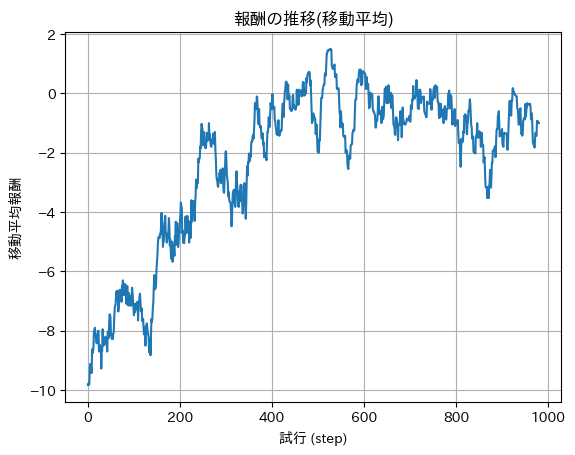

In [8]:
window = 20
moving_avg = np.convolve(reward_log, np.ones(window)/window, mode='valid')

plt.plot(moving_avg)
plt.xlabel("試行 (step)")
plt.ylabel('移動平均報酬')
plt.title("報酬の推移(移動平均)")
plt.grid()
plt.show()

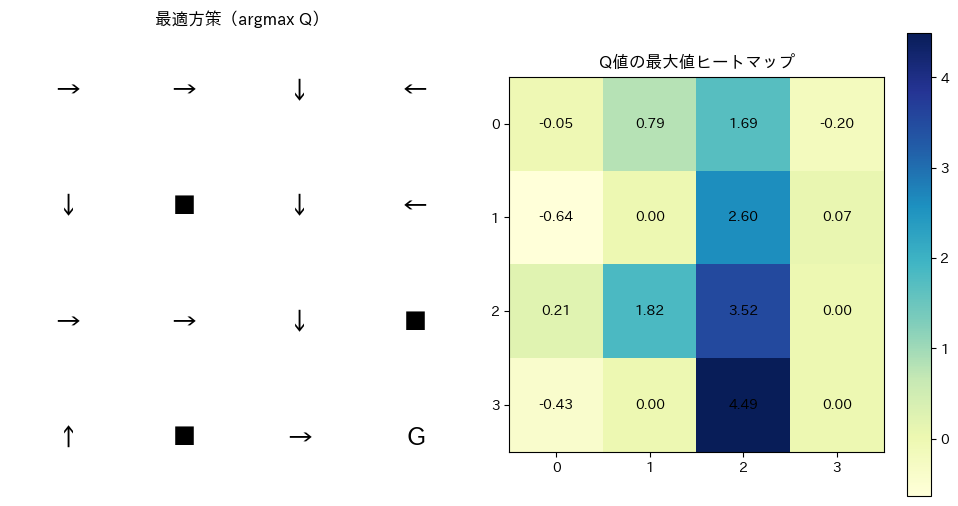

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy_and_q_values(q_table, grid_env):
    size = grid_env.size
    policy = np.argmax(q_table, axis=1)
    action_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    arrows = np.vectorize(action_symbols.get)(policy.reshape((size, size)))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # --- ① 方策の矢印マップ ---
    axs[0].set_title("最適方策（argmax Q）")
    axs[0].axis("off")

    for i in range(size):
        for j in range(size):
            state = (i, j)
            idx = i * size + j
            if state in grid_env.holes:
                axs[0].text(j, i, '■', ha='center', va='center', fontsize=18)
            elif state == grid_env.goal:
                axs[0].text(j, i, 'G', ha='center', va='center', fontsize=18)
            else:
                axs[0].text(j, i, arrows[i, j], ha='center', va='center', fontsize=18)
    axs[0].set_xlim(-0.5, size - 0.5)
    axs[0].set_ylim(size - 0.5, -0.5)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_aspect('equal')

    # --- ② Q値ヒートマップ（最大Q値のみ表示） ---
    max_q_values = np.max(q_table, axis=1).reshape((size, size))
    im = axs[1].imshow(max_q_values, cmap='YlGnBu')

    for i in range(size):
        for j in range(size):
            axs[1].text(j, i, f"{max_q_values[i, j]:.2f}", ha="center", va="center", color="black")

    axs[1].set_title("Q値の最大値ヒートマップ")
    axs[1].set_xticks(range(size))
    axs[1].set_yticks(range(size))
    axs[1].set_aspect('equal')

    fig.colorbar(im, ax=axs[1])
    plt.tight_layout()
    plt.show()

visualize_policy_and_q_values(q_table, grid_env)


In [6]:
q_table

array([[-1.0611204 , -0.03823822, -1.0998393 , -1.0816171 ],
       [-0.6705825 ,  0.8005229 , -2.6381276 , -0.83097345],
       [-0.22014762, -0.52470136,  1.6882844 , -0.4156337 ],
       [-0.374766  , -0.3815895 , -0.3747703 , -0.18753347],
       [-0.80119485, -1.349044  , -0.68942785, -0.78871375],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.12672497, -0.29804415,  2.5942209 , -2.1049044 ],
       [-0.27373952, -0.2699074 , -0.5756396 ,  0.0777339 ],
       [-0.49790168,  0.09977984, -0.47098422, -0.46504065],
       [-0.7218981 ,  1.6063492 , -0.95607257, -0.21990117],
       [ 0.27562812, -1.8206553 ,  3.5189352 ,  0.14563063],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.4407985 , -0.62488323, -0.43937716, -0.43503538],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.62494504,  4.493453  ,  1.0276989 , -2.0706105 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)